# Import libraries

In [35]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
from PIL import Image
from torchvision import datasets, models
import importlib
import seaborn as sns
from torch.autograd import Variable
from torchvision.models import ResNet50_Weights
import math

manual_seed = 999
random.seed(manual_seed)
torch.manual_seed(manual_seed)
torch.use_deterministic_algorithms(True)
generator = torch.Generator().manual_seed(manual_seed)

# Parameter values

In [2]:
image_size = 224

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010])
])

ngpu = 1
device = torch.device('cuda:0' if (torch.cuda.is_available() and ngpu > 0) else 'cpu')
print(device.type)

cpu


# Dataset load

In [3]:
dataset_path = 'utk-dataset-jpg'
workers = 2
batch_size = 100
num_epochs = 50
lr = 0.0001
image_size = 224
# number of available gpu's
ngpu = 1
# num of image channels
nc = 3
nf = 32

In [9]:
image_limit = 500

class RegressionDataset(Dataset):

    def __init__(self, transform=None) -> None:
        super().__init__()
        self.transform = transform
        self.paths = [item for sublist in [[os.path.join(x, y) for y in os.listdir(x)] for x in [os.path.join(dataset_path, x) for x in os.listdir(dataset_path)]] for item in sublist]
        occur_dict = {}
        for a in range(1, 100+1):
            occur_dict[a] = 0
        
        new_paths = []
        for path in self.paths:
            age = int(path.split('/')[-2])
            if occur_dict[age] > image_limit:
                continue
            occur_dict[age] += 1
            new_paths.append(path)
        self.paths = new_paths
        
        self.labels = [float(x.split('/')[-2]) for x in self.paths]
        #self.labels = [(x - 50) / 50 for x in self.labels]
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        path = self.paths[index]
        label = self.labels[index]
        img = cv2.imread(path)
        img = Image.fromarray(img, mode='RGB')

        if self.transform:
            img = self.transform(img)
        
        return img, label

regression_dataset = RegressionDataset(transform=transform)

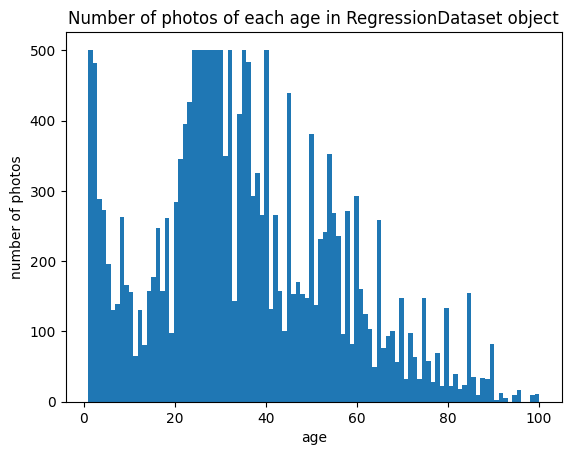

In [6]:
plt.hist([round(x) for x in regression_dataset.labels], bins=100)
plt.title('Number of photos of each age in RegressionDataset object')
plt.xlabel('age')
plt.ylabel('number of photos')
plt.show()

# Load resnet model

In [7]:
resnet = models.resnet50(pretrained=True).to(device)

/home/dawid/anaconda3/envs/linReg/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dawid/anaconda3/envs/linReg/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/dawid/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [02:44<00:00, 624kB/s] 


# Convolution Exploration

In [8]:
resnet_weights = []
conv_layers = []

resnet_children = list(resnet.children())

counter = 0

for i, children in enumerate(resnet_children):
    if type(children) == nn.Conv2d:
        counter += 1
        resnet_weights.append(children.weight)
        conv_layers.append(children)
    elif type(children) == nn.Sequential:
        for j in range(len(children)):
            for child in children[j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    resnet_weights.append(child.weight)
                    conv_layers.append(child)

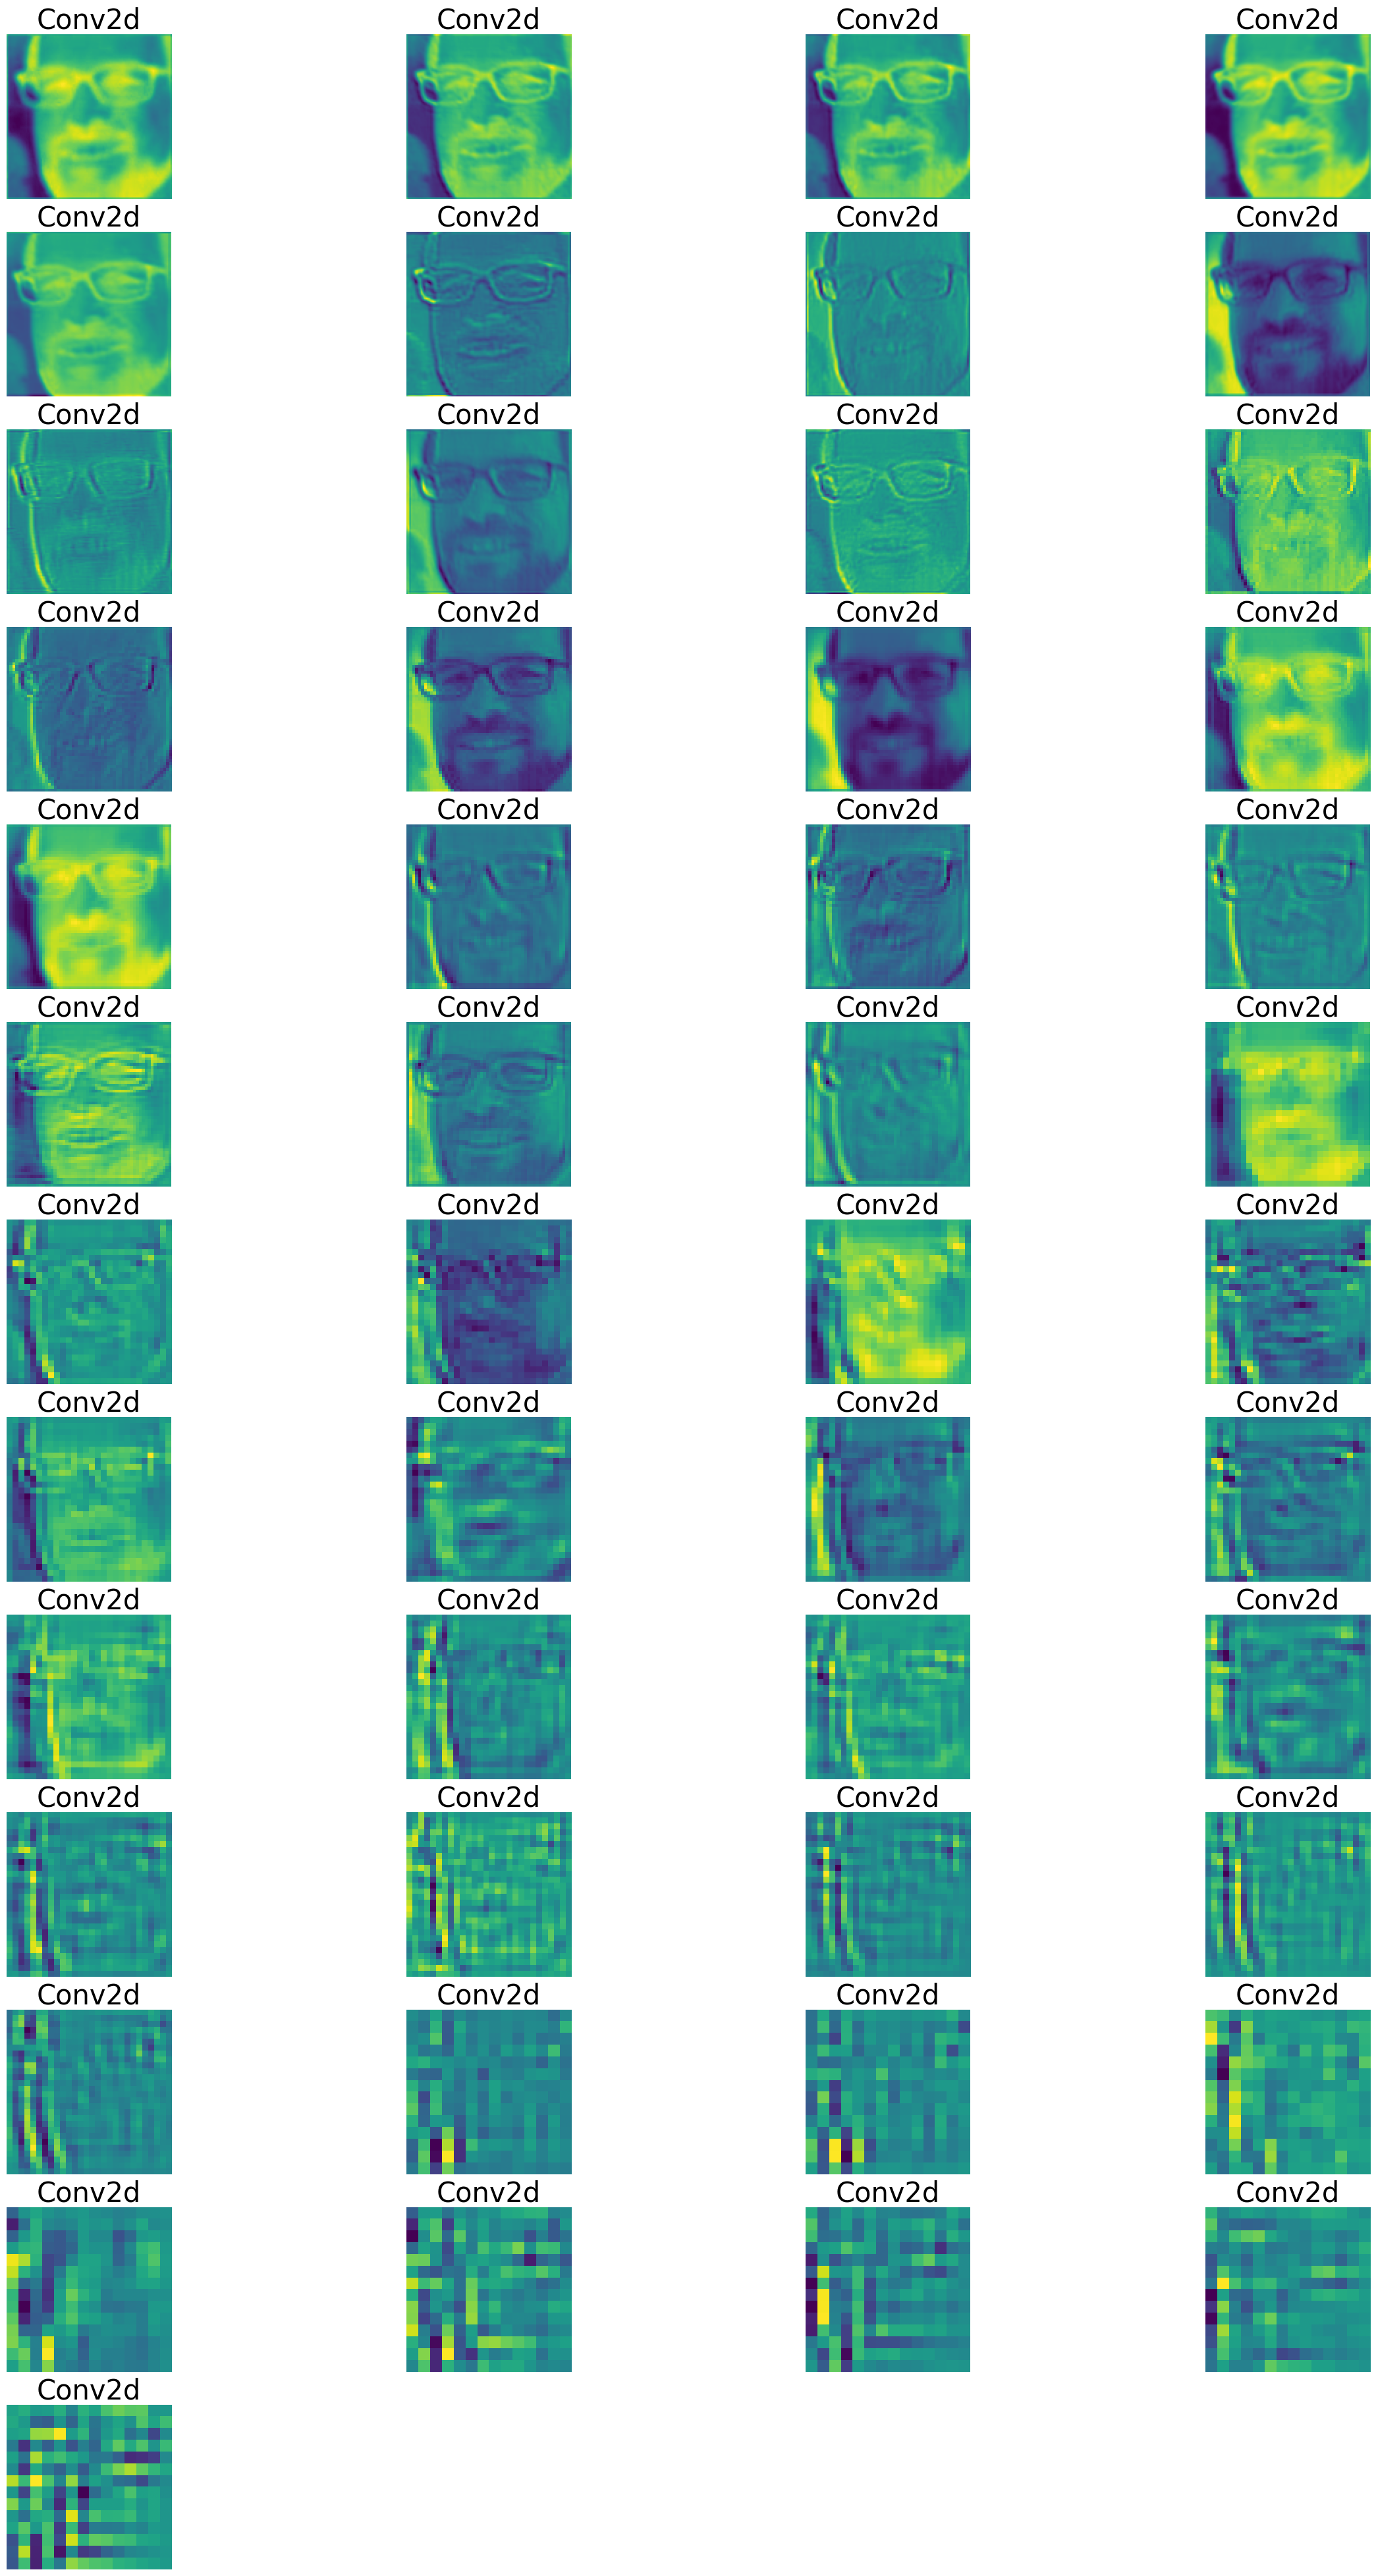

In [12]:
test_img, _ = regression_dataset[0]

outputs = []
names = []
for layer in conv_layers[0:]:
    test_img = layer(test_img)
    outputs.append(test_img)
    names.append(str(layer))

processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map, 0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())

fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(13, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)

# Output exploration

## Load model and set the last layer to Identity layer

In [13]:
resnet = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(device)
resnet.fc = nn.Sequential(nn.Identity())

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/dawid/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [02:45<00:00, 618kB/s] 


In [25]:
from scipy.signal import savgol_filter

def plot_curve(idx):

    test_img, test_img_label = regression_dataset[idx]
    test_img = test_img.detach()
    test_img = test_img.reshape((1, nc, image_size, image_size))

    res = resnet(test_img)
    res = res.detach().cpu().numpy().reshape(-1)
    
    res = savgol_filter(res, 101, 2)
    plt.plot(res)
    
    dot = '.'
    plt.title(f'Encoded photo of a {round(test_img_label)} year old')

In [29]:
random_idx = [random.randint(0, len(regression_dataset) - 1) for i in range(5)]
print(random_idx)

[8669, 18708, 1741, 8313, 13043]


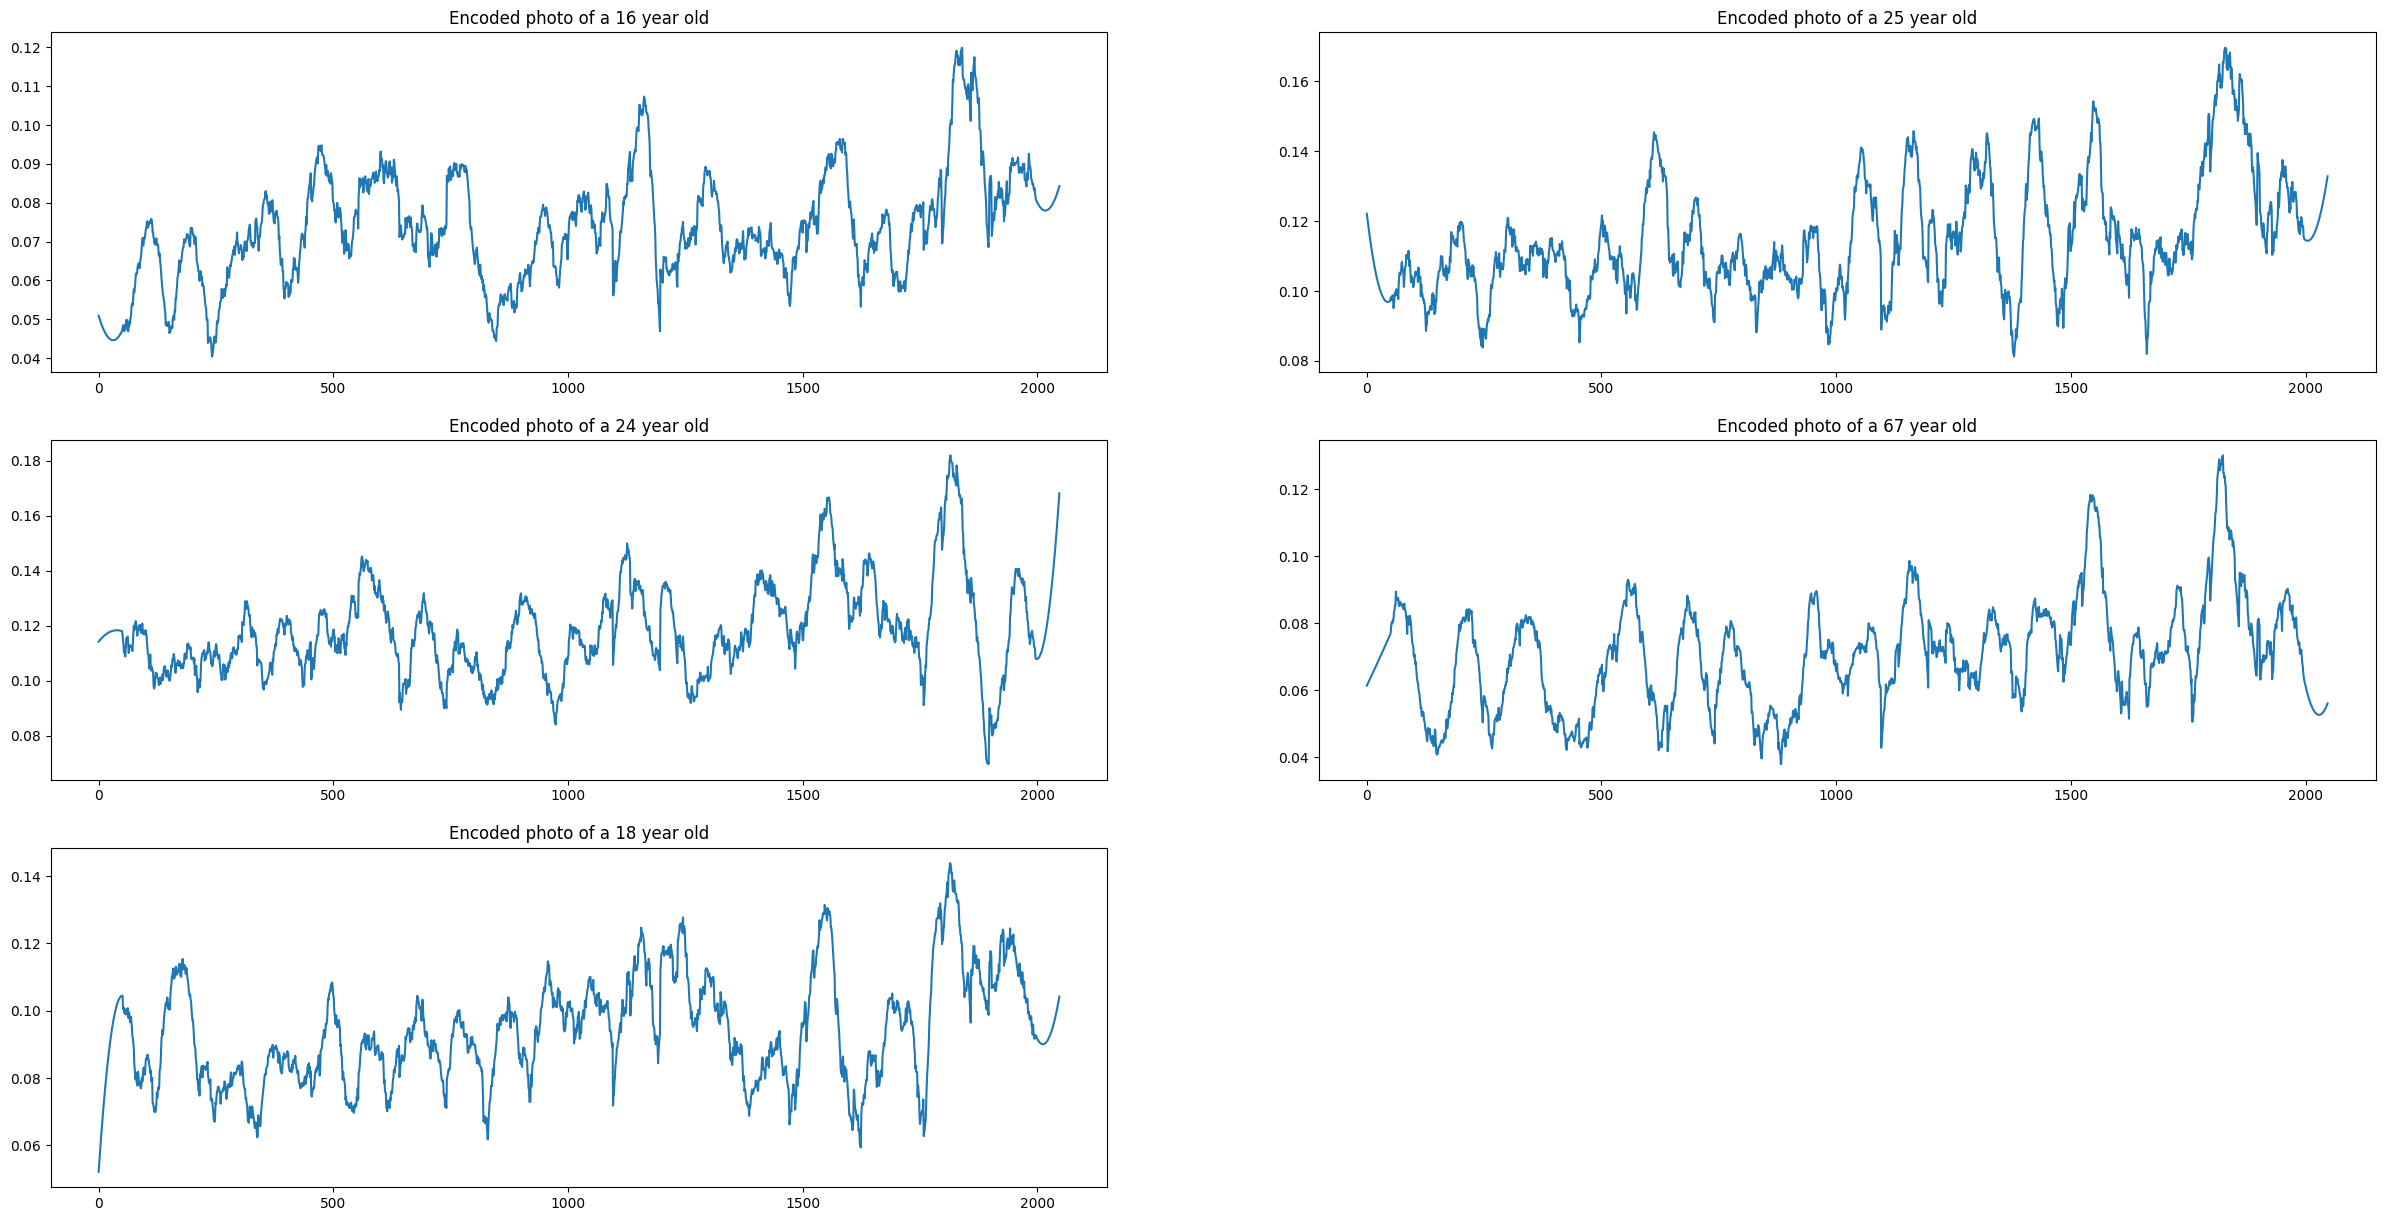

In [40]:
fig = plt.figure(figsize=(30, 15))
cols = 2
rows = math.ceil(len(random_idx) / cols)
for i, ran_idx in enumerate(random_idx):
    a = fig.add_subplot(rows, cols, i+1)
    plot_curve(ran_idx)

# Similarity

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
from itertools import product

In [22]:
sim_images_names = [
    'dawid.jpeg',
    'domino.png',
    'kubus.jpg',
    'zuzia.jpg',
    'kapitan.jpg',
    'przelas.jpg',
    'bieszczady.jpeg'
]

sim_images = [cv2.imread(x) for x in sim_images_names]
sim_images = [Image.fromarray(x, mode='RGB') for x in sim_images]
sim_images = [transform(x).to(device).detach().reshape((1, 3, image_size, image_size))
 for x in sim_images]

In [49]:
sim_images = [regression_dataset[idx][0] for idx in random_idx]
sim_images = [img.reshape((1, nc, image_size, image_size)) for img in sim_images]

sim_labels = [regression_dataset[idx][1] for idx in random_idx]
sim_labels = [round(l) for l in sim_labels]

In [46]:
def extract_feature_vector(img):
    fv = resnet(img)
    # fv = extract_feature_vector_2(img)
    fv = fv.detach().cpu().numpy().reshape(-1)
    return fv

sim_matrix = np.zeros((len(sim_images), len(sim_images)))
    
for i, j in product(range(len(sim_images)), range(len(sim_images))):
    fv_i = extract_feature_vector(sim_images[i])
    fv_j = extract_feature_vector(sim_images[j])
    sim_score = cosine_similarity([fv_i], [fv_j])[0][0]
    sim_matrix[i, j] = sim_score

Text(0.5, 1.0, 'Similarity of feature vectors of photos with given age')

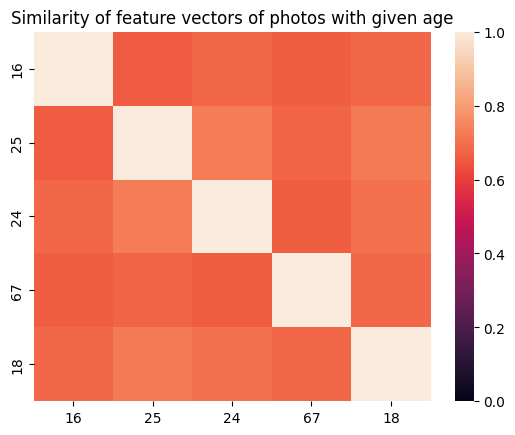

In [52]:
sns.heatmap(sim_matrix, vmin=0, vmax=1,
            xticklabels=sim_labels,
            yticklabels=sim_labels,)
plt.title('Similarity of feature vectors of photos with given age')